In [1]:
import pandas as pd
import polars as pl

import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import util

In [2]:
RANDOM_SEED = 42

READ_ORIGINS="/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
MINIMAP2_OVLPS="/storage2/tbrekalo/HG002-simulated/chr19-ovlps.paf"

In [3]:
df_ovlps = util.create_annotated_overlaps_from_ava(
    df_overlaps=util.load_paf_df(MINIMAP2_OVLPS),
    df_origins=util.load_origins_df(READ_ORIGINS),
)

In [12]:
df_features = (
    df_ovlps.select(
        (pl.col("query-end") - pl.col("query-start")).alias("query-overlap-length"),
        (pl.col("target-end") - pl.col("target-start")).alias("target-overlap-length"),
        pl.col("n-residue-matches"),
        pl.col("strand"),
        pl.col("label"),
    )
    .with_columns(
        pl.max_horizontal(
            pl.col("query-overlap-length"), pl.col("target-overlap-length")
        ).alias("overlap-length"),
    )
    .with_columns(
        (
            (
                (pl.col("query-overlap-length") - pl.col("target-overlap-length")) ** 2
            ).sqrt()
            / pl.col("overlap-length")
        ).alias("overlap-length-diff-norm"),
        (pl.col("n-residue-matches") / pl.col("overlap-length")).alias(
            "n-residue-matches-norm"
        ),
    )
)

df_features

query-overlap-length,target-overlap-length,n-residue-matches,strand,label,overlap-length,overlap-length-diff-norm,n-residue-matches-norm
i64,i64,i64,i32,i64,i64,f64,f64
19095,19097,16983,0,0,19097,0.000105,0.889302
17669,17674,15708,0,0,17674,0.000283,0.888763
17591,17599,15561,0,0,17599,0.000455,0.884198
17292,17296,15436,0,0,17296,0.000231,0.892461
16514,16521,14719,1,0,16521,0.000424,0.890927
16778,16810,14656,0,0,16810,0.001904,0.871862
16153,16161,14306,0,0,16161,0.000495,0.885217
15989,15993,14143,1,0,15993,0.00025,0.884324
15660,15662,13776,0,0,15662,0.000128,0.879581


<Axes: xlabel='label', ylabel='len'>

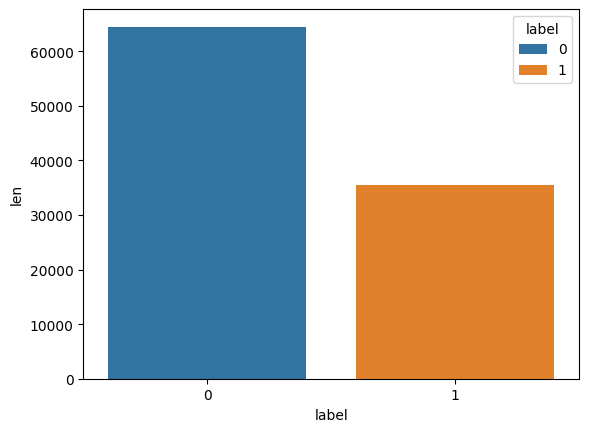

In [13]:
sns.barplot(
    df_features.top_k(5_000_000, by="label").sample(100_000, seed=RANDOM_SEED).group_by("label").agg(pl.len()).to_pandas(),
    x="label",
    y="len",
    hue="label",
)

In [15]:
df_model = df_features.top_k(5_000_000, by="label").sample(100_000, seed=RANDOM_SEED).to_pandas()

In [16]:
data = util.TrainTestData(*train_test_split(
    df_model.drop(["label"], axis=1),
    df_model[["label"]],
    test_size=0.3,
    random_state=RANDOM_SEED,
))

In [18]:
cb_pool = cb.Pool(
    df_model.drop(["label"], axis=1),
    label=df_model[["label"]],
    cat_features=["strand"],
)

In [21]:
cb_params = {
    "iterations": 1_000,
    "loss_function": "Logloss",
    "boosting_type": "Plain",
    "verbose": False,
    "max_depth": 6
}

In [22]:
scores = cb.cv(cb_pool, cb_params, fold_count=3, plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


KeyboardInterrupt: 

In [ ]:
models = {
    "catboost": cb.CatBoostClassifier(
        iterations=100,
        random_seed=RANDOM_SEED,
        cat_features=["strand"],
        verbose=10,
    ),
    "logistic-regression": LogisticRegression(),
}

In [ ]:
models['catboost'].fit()